In [ ]:
import math, random, re
from collections import defaultdict, Counter
from bs4 import BeautifulSoup
import requests
import pandas as pd
from matplotlib import pyplot as plt
import json

# Processamento de Linguagem Natural

Processamento de linguagem natural (ou *Natural Language Processing - NLP*) refere-se a técnicas computacionais envolvendo linguagem. É um campo amplo, mas vamos ver algumas técnicas simples e outras não tão simples.

## Nuvens de palavras

Nas primeiras aulas, calculamos as contagens de palavras dos interesses dos usuários. Uma abordagem para visualizar palavras e contagens é através de nuvens de palavras, que artisticamente apresentam as palavras com tamanhos proporcionais às suas contagens.

Geralmente, porém, os cientistas de dados não pensam muito em nuvens de palavras, em grande parte porque o posicionamento das palavras não significa nada além de "aqui está um espaço em que eu consegui encaixar uma palavra".

Se você for forçado a criar uma nuvem de palavras, pense se consegue fazer com que os eixos transmitam algo. Por exemplo, imagine que, para cada uma de algumas coleções de chavões relacionados à ciência de dados, você tem dois números entre 0 e 100 - o primeiro representando a frequência com que aparece nas publicações de emprego, o segundo com que frequência aparece nos currículos. Esses dados estão no arquivo [science_buzz_words.csv](https://www.dropbox.com/s/hjgqnhqtt8gcmd0/science_buzz_words.csv?dl=0). Vamos carregá-lo:

In [ ]:
df = pd.read_csv('./data/science_buzz_words.csv')
df

A abordagem de nuvem de palavras é apenas para organizar as palavras em uma página em uma fonte legal:

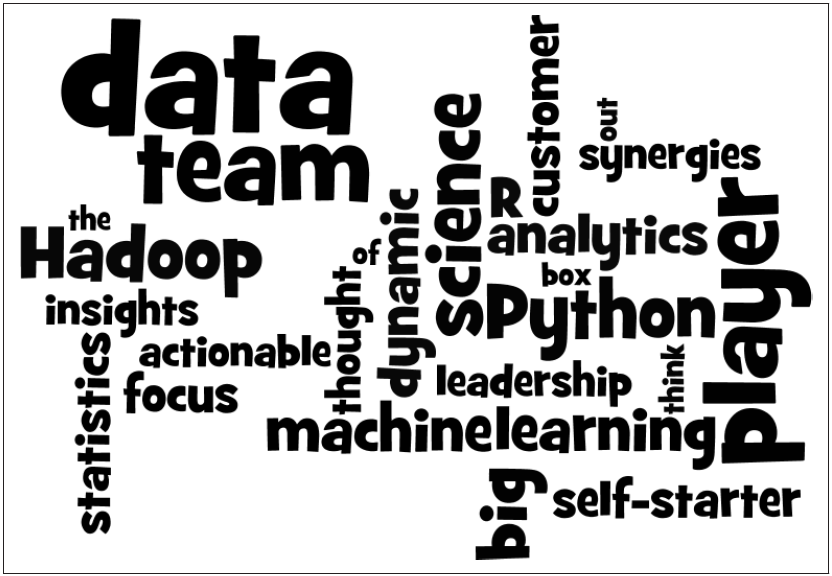

Isso parece legal, mas não nos diz nada. Uma abordagem mais interessante pode ser espalhá-los de modo que a posição horizontal indique a popularidade em publicações de emprego e a posição vertical a popularidade em currículos, o que produz uma visualização que transmite alguns *insights*:

In [ ]:
def text_size(total):
    """equals 8 if total is 0, 28 if total is 200"""
    return 8 + total / 200 * 20

data = df.values
fig = plt.figure()
for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
             ha='center', va='center', color="b",
             size=text_size(job_popularity + resume_popularity))
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.show()
fig.savefig('wordcloud1.png', dpi=150)

## Modelos n-gram

O diretor de marketing de mecanismos de busca da *DataSciencester* deseja criar milhares de páginas da Web sobre ciência de dados para que seu site tenha uma classificação mais alta nos resultados de pesquisa para termos relacionados à ciência de dados. (Você tenta explicar a ela que os algoritmos dos mecanismos de pesquisa são inteligentes o suficiente para que isso não funcione, mas ele se recusa a ouvir.)

Claro, ele não quer escrever milhares de páginas da web, nem quer pagar uma horda de "estrategistas de conteúdo" para fazê-lo. Em vez disso, ele pergunta se você pode de alguma forma gerar programaticamente essas páginas da web. Para fazer isso, precisaremos de um jeito de modelar a linguagem.

Uma abordagem é começar com um corpus de documentos e aprender um modelo estatístico de linguagem. No nosso caso, começaremos com o ensaio de Mike Loukides, ["O que é ciência de dados?"](https://www.oreilly.com/ideas/what-is-data-science)

Como na Aula 10, usaremos solicitações e BeautifulSoup para recuperar os dados. Há um par de questões que merecem atenção.

A primeira é que os apóstrofos no texto são, na verdade, o caractere Unicode `u"\u2019"`. Vamos criar uma função auxiliar para substituí-los por apóstrofos normais:

In [ ]:
def fix_unicode(text):
    return text.replace(u"\u2019", "'")

A segunda questão é que, assim que recebermos o texto da página da web, queremos dividi-la em uma sequência de palavras e pontos (para que possamos saber onde as frases terminam). Podemos fazer isso usando re.findall():

In [ ]:
def get_document():

    url = "http://radar.oreilly.com/2010/06/what-is-data-science.html"
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html5lib')

    content = soup.find("div", "article-body")         # find article-body div
    regex = r"[\w']+|[\.]"                             # matches a word or a period

    document = []


    for paragraph in content("p"):
        words = re.findall(regex, fix_unicode(paragraph.text))
        document.extend(words)

    return document

document = get_document()

In [ ]:
document

Nós certamente poderíamos (e provavelmente deveríamos) limpar esses dados ainda mais. Ainda há alguma quantidade de texto estranho no documento (por exemplo, a primeira palavra é "We've") e dividimos as frases a partir de pontos que não são, na verdade, pontos finais (por exemplo, em "Web 2.0"), e há um punhado de legendas e listas por toda parte. Dito isso, trabalharemos com o documento como ele é.

Agora que temos o texto como uma sequência de palavras, podemos modelar a linguagem da seguinte maneira: dada uma palavra inicial (digamos, "web"), olhamos todas as palavras que a seguem nos documentos de origem (aqui "2", "is", "front", "was", "server", "has", "friend", "services" etc). Nós escolhemos aleatoriamente uma dessas para ser a próxima palavra, e repetimos o processo até chegarmos a um ponto, que significa o fim da frase. Chamamos isso de *modelo bigrama*, como é determinado completamente pelas freqüências dos bigramas (pares de palavras) nos dados originais.

Que tal uma palavra inicial? Podemos escolher aleatoriamente de palavras que seguem um ponto. Para começar, vamos precomputar as possíveis transições de palavras. Lembre-se de que o `zip` para quando qualquer uma de suas entradas terminar, de modo que `zip(document, document[1:])` fornece precisamente os pares de elementos consecutivos do documento:

In [ ]:
bigrams = zip(document, document[1:])
transitions = defaultdict(list)
for prev, current in bigrams:
    transitions[prev].append(current)

Agora estamos prontos para gerar sentenças:

In [ ]:
def generate_using_bigrams(transitions):
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done



As frases produzidas são sem sentido, mas são o tipo de tagarelice que você pode colocar no seu site se estiver tentando soar como se fosse um site de ciência dos dados. Por exemplo:

In [ ]:
sentence = generate_using_bigrams(transitions)
print("Frase gerada pelo modelo bigrama:\n")
print(sentence)

Podemos tornar as frases menos sem sentido, olhando para trigramas, triplas de palavras consecutivas. (Em geral, você pode ver n-gramas consistindo de n palavras consecutivas, mas três serão suficientes para nós.) Agora as transições dependerão das duas palavras anteriores:

In [ ]:
trigrams = zip(document, document[1:], document[2:])
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in trigrams:
    if prev == ".": # if the previous "word" was a period
        starts.append(current) # then this is a start word
        
    trigram_transitions[(prev, current)].append(next)

Observe que agora temos que rastrear as palavras iniciais separadamente. Podemos gerar sentenças praticamente da mesma maneira:

In [ ]:
def generate_using_trigrams(starts, trigram_transitions):
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next = random.choice(next_word_candidates)

        prev, current = current, next
        result.append(current)

        if current == ".":
            return " ".join(result)


Essa função vai produzir sentenças como:

In [ ]:
sentence = generate_using_trigrams(starts, trigram_transitions)
print("Frase gerada pelo modelo trigrama:\n")
print(sentence)

Claro, elas soam melhor porque a cada passo o processo de geração tem menos escolhas, e em muitos passos há apenas uma única escolha. Isso significa que você freqüentemente gerará frases (ou pelo menos frases longas) que foram vistas literalmente nos dados originais. Ter mais dados ajudaria; também funcionaria melhor se você coletasse *n-gramas* de vários ensaios sobre ciência de dados.

## Gramáticas

Uma abordagem diferente para modelar a linguagem é com gramáticas, ou regras para gerar sentenças aceitáveis. Na escola primária, você provavelmente aprendeu sobre partes do discurso (*parts of speech*) e como combiná-las. Por exemplo, se você tivesse um professor muito ruim, poderia dizer que uma sentença consiste necessariamente em um substantivo seguido de um verbo. Se você tiver uma lista de substantivos e verbos, poderá gerar sentenças de acordo com a regra.

Vamos definir uma gramática um pouco mais complicada:

In [ ]:
grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

Eu inventei a convenção de que os nomes que começam com sublinhados ('_') se referem a *regras* que precisam ser expandidas e que outros nomes são terminais que não precisam de processamento adicional.

Assim, por exemplo, "_S" é a regra "sentença", que produz uma regra "_NP" ("frase de substantivo", ou *"noun phrase*") seguida por uma regra "_VP" ("frase verbal" ou "*verb phrase*").

A regra de frase verbal pode produzir a regra "_V" ("verbo") ou a regra de verbo seguida pela regra de frase de substantivo.

Observe que a regra "_NP" se contém em uma de suas produções. As gramáticas podem ser recursivas, o que permite que até mesmo gramáticas finitas como essa gerem infinitas sentenças diferentes.

Como geramos sentenças dessa gramática? Começaremos com uma lista contendo a regra da sentença `["_S"]`. Depois, expandimos repetidamente cada regra, substituindo-a por uma de suas produções escolhidas aleatoriamente. Paramos quando temos uma lista consistindo apenas de terminais.

Por exemplo, uma dessas progressões pode ser:

```
['_S']
['_NP','_VP']
['_N','_VP']
['Python','_VP']
['Python','_V','_NP']
['Python','trains','_NP']
['Python','trains','_A','_NP','_P','_A','_N']
['Python','trains','logistic','_NP','_P','_A','_N']
['Python','trains','logistic','_N','_P','_A','_N']
['Python','trains','logistic','data science','_P','_A','_N']
['Python','trains','logistic','data science','about','_A', '_N']
['Python','trains','logistic','data science','about','logistic','_N']
['Python','trains','logistic','data science','about','logistic','Python']
```

Como implementamos isso? Bem, para começar, vamos criar uma função auxiliar simples para identificar terminais:

In [ ]:
def is_terminal(token):
    return token[0] != "_"

Em seguida, precisamos escrever uma função para transformar uma lista de tokens em uma sentença. Vamos procurar o primeiro token não terminal. Se não conseguimos encontrar um, significa que temos uma frase completa e estamos prontos.

Se encontrarmos um não-terminal, então escolhemos aleatoriamente uma de suas produções. Se essa produção é um terminal (ou seja, uma palavra), simplesmente substituímos o token por ele. Caso contrário, é uma sequência de tokens não-terminais separados por espaço que precisamos dividir e depois dividir nos tokens atuais. De qualquer forma, repetimos o processo no novo conjunto de tokens.

Colocando tudo junto, temos:

In [ ]:
def expand(grammar, tokens):
    for i, token in enumerate(tokens):

        # ignore terminals
        if is_terminal(token): continue

        # choose a replacement at random
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
            
        # now call expand on the new list of tokens
        return expand(grammar, tokens)

    # if we get here we had all terminals and are done
    return tokens

Agora podemos começar a gerar sentenças:

In [ ]:
def generate_sentence(grammar):
    return expand(grammar, ["_S"])

In [ ]:
print("Sentenças da gramática:\n")
for i in range(10):
    print(i, " ".join(generate_sentence(grammar)))
print()

Tente mudar a gramática - adicione mais palavras, adicione mais regras, adicione suas próprias partes do discurso - até que esteja pronto para gerar o máximo de páginas da Web que sua empresa precisar.

As gramáticas são realmente mais interessantes quando usadas na outra direção. Dada uma sentença, podemos usar uma gramática para analisar a sentença. Isso nos permite identificar assuntos e verbos e nos ajuda a entender a sentença.

Usar a ciência de dados para gerar texto é um truque legal; usá-lo para entender o texto é mais mágico.

## Um aparte: Gibbs Sampling

Gerar amostras de algumas distribuições é fácil. Podemos obter variáveis aleatórias uniformes com:

`random.random()`

e variáveis aleatórias normais com:

`inverse_normal_cdf(random.random())`

Mas algumas distribuições são mais difíceis de serem amostradas. A amostragem de Gibbs é uma técnica para gerar amostras de distribuições multidimensionais quando apenas conhecemos algumas das distribuições condicionais.

Por exemplo, imagine rodar dois dados. Seja $x$ o valor do primeiro dado e $y$ a soma dos dados, e imagine que você queira gerar muitos pares $(x, y)$. Nesse caso, é fácil gerar as amostras diretamente:

In [ ]:
def roll_a_die():
    return random.choice([1,2,3,4,5,6])

def direct_sample():
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

Mas imagine que você conhecesse apenas as distribuições condicionais. A distribuição de $y$ condicional em $x$ é fácil - se você sabe que o valor de $x, y$ é igualmente provável que seja $x + 1, x + 2, x + 3, x + 4, x + 5$ ou $x + 6$:

In [ ]:
def random_y_given_x(x):
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

A outra direção é mais complicada. Por exemplo, se você sabe que $y$ é $2$, então necessariamente $x$ é $1$ (já que a única maneira pela qual dois dados podem somar 2 é se ambos forem 1). Se você sabe que $y$ é $3$, então $x$ é igualmente provável que seja $1$ ou $2$. Similarmente, se $y$ é $11$, então $x$ tem que ser $5$ ou $6$:

In [ ]:
def random_x_given_y(y):
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

A forma como a amostragem de Gibbs funciona é que começamos com qualquer valor (válido) para $x$ e $y$ e, em seguida, repetidamente  substituindo $x$ por um valor aleatório escolhido condicional em $y$ e substituindo $y$ por um valor aleatório escolhido condicional a este novo $x$. Após várias iterações, os valores resultantes de $x$ e $y$ representarão uma amostra da distribuição conjunta incondicional:

In [ ]:
def gibbs_sample(num_iters=100):
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

Você pode verificar se isso fornece resultados semelhantes à amostra direta:

In [ ]:
def compare_distributions(num_samples=1000):
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [ ]:
print("gibbs sampling")
comparison = compare_distributions()
errors = []
for roll, (gibbs, direct) in comparison.items():
    errors.append(direct - gibbs)
    print(roll, gibbs, direct)

In [ ]:
fig = plt.figure()    
plt.hist(errors)
plt.xlabel("errors")
plt.ylabel("count")
plt.show()
fig.savefig("gibbserrors.png", dpi=150)

## Modelagem de Tópicos

Quando criamos nossa recomendação de "cientistas de dados que você deveria conhecer" na Aula01, simplesmente procuramos por correspondências exatas nos interesses declarados das pessoas.

Uma abordagem mais sofisticada para entender os interesses de nossos usuários pode ser tentar identificar os tópicos subjacentes a esses interesses. Uma técnica chamada *Latent Dirichlet Allocation (LDA)* é comumente usada para identificar tópicos comuns em um conjunto de documentos. Vamos aplicá-la aos documentos que consistem nos interesses de cada usuário.

O LDA tem algumas semelhanças com o classificador *Naive Bayes* que construímos no Capítulo 13, na medida em que assume um modelo probabilístico para documentos. Nós vamos passar por cima dos detalhes matemáticos mais complicados, mas para nossos propósitos o modelo assume que:

* Existe algum número fixo de tópicos $K$.
* Existe uma variável aleatória que atribui a cada tópico uma distribuição de probabilidade associada às palavras. Você deve pensar nesta distribuição como a probabilidade de ver a palavra $w$ dada o tópico $k$.
* Existe outra variável aleatória que atribui a cada documento uma distribuição de probabilidade sobre os tópicos. Você deve pensar nessa distribuição como a mistura de tópicos no documento $d$.
* Cada palavra em um documento foi gerada primeiro escolhendo aleatoriamente um tópico (da distribuição de tópicos do documento) e depois escolhendo aleatoriamente uma palavra (da distribuição de palavras do tópico).

Em particular, temos uma coleção de documentos, cada um dos quais é uma lista de palavras. E temos uma coleção correspondente de `document_topics` que atribui um tópico (aqui um número entre $0$ e $K-1$) a cada palavra em cada documento.

Então, a quinta palavra no quarto documento é:

`documents[3][4]`

e o tópico do qual esta palavra foi escolhida é:

`document_topics[3][4]`

Isso define muito explicitamente a distribuição de cada documento em relação a tópicos e define implicitamente a distribuição de cada tópico em relação às palavras.

Podemos estimar a probabilidade de que o tópico 1 produza uma determinada palavra comparando quantas vezes o tópico 1 produz essa palavra com quantas vezes o tópico 1 produz *qualquer* palavra. (Da mesma forma, quando criamos um filtro de spam na Aula13, comparamos quantas vezes cada palavra apareceu em spams com o número total de palavras que aparecem em spams.)

Embora esses tópicos sejam apenas números, podemos dar-lhes nomes descritivos, observando as palavras nas quais eles atribuem maior peso. Nós apenas temos que de alguma forma gerar o document_topics. É aqui que a amostragem de Gibbs entra em cena.

Começamos atribuindo a cada palavra em cada documento um tópico completamente aleatório. Agora passamos por cada documento, uma palavra por vez. Para essa palavra e documento, construímos pesos para cada tópico que depende da distribuição (atual) de tópicos nesse documento e da distribuição (atual) de palavras para esse tópico. Em seguida, usamos esses pesos para amostrar um novo tópico para essa palavra. Se iterarmos esse processo muitas vezes, acabaremos com uma amostra conjunta da distribuição de (tópico,palavra)s e da distribuição de (documento,tópico)s.

Para começar, precisamos de uma função para escolher aleatoriamente um índice com base em um conjunto arbitrário de pesos:

In [ ]:
def sample_from(weights):
    total = sum(weights)
    rnd = total * random.random()       # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                        # return the smallest i such that
        if rnd <= 0: return i # sum(weights[:(i+1)]) >= rnd

Por exemplo, se você der pesos `[1, 1, 3]`, então um quinto do tempo retornará `0`, um quinto do tempo retornará `1` e três quintos do tempo retornará `2`.

Nossos documentos são os interesses de nossos usuários. Vamos carregar uma amostra desses interesses que está no arquivo [`interests_users.json`](https://www.dropbox.com/s/jstv54glst9o0ju/interests_users.json?dl=0):

In [ ]:
with open('./data/interests_users.json') as json_file:  
    documents = json.load(json_file)
for document in documents:
    print(document)

E vamos tentar encontrar $K = 4$ tópicos.

Para calcular os pesos de amostragem, precisamos acompanhar várias contagens. Vamos primeiro criar as estruturas de dados para eles.

Quantas vezes cada tópico é atribuído a cada documento:

In [ ]:
# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

Quantas vezes cada palavra é atribuída a cada tópico:

In [ ]:
K = 4
# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

O número total de palavras atribuído a cada tópico:

In [ ]:
#a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

O número total de palavras contida em cada documento:

In [ ]:
# a list of numbers, one for each document
document_lengths = [len(d) for d in documents]

O número distinto de palavras:

In [ ]:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)
print("numero de palavras distintas: ", W)

E o número de documentos:

In [ ]:
D = len(documents)
print("numero de documentos:", D)

Por exemplo, uma vez que populamos esses, podemos encontrar o número de palavras em `documents[3]` associadas com o tópico $1$ com (que por enquanto é $0$):

In [ ]:
document_topic_counts[3][1]

E podemos encontrar o número de vezes que "nlp" é associado com o tópico $2$ com (que por enquanto, também é $0$):

In [ ]:
topic_word_counts[2]["nlp"]

Agora estamos prontos para definir nossas funções de probabilidade condicional. Como na Aula12, cada um tem um termo de suavização que garante que cada tópico tenha uma chance diferente de zero de ser escolhido em qualquer documento e que cada palavra tenha uma chance diferente de zero de ser escolhida para qualquer tópico:

In [ ]:
def p_topic_given_document(topic, d, alpha=0.1):
    """the fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)"""

    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word, topic, beta=0.1):
    """the fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)"""

    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))


Vamos usar esses para criar os pesos para atualizar os tópicos:

In [ ]:
def topic_weight(d, word, k):
    """given a document and a word in that document,
    return the weight for the k-th topic"""

    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])


Existem razões matemáticas sólidas pelas quais `topic_weight` é definido como é, mas seus detalhes nos levariam muito longe. Espero que pelo menos o sentido intuitivo seja que - dada uma palavra e seu documento - a probabilidade de qualquer escolha de tópico depende tanto do quão provável o tópico é para o documento quanto do quão provável a palavra é para o tópico.

Essa é toda a maquinaria que precisamos. Começamos atribuindo cada palavra a um tópico aleatório e preenchendo nossos contadores apropriadamente:

In [ ]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1


Nosso objetivo é obter uma amostra conjunta da distribuição de tópicos-palavras e da distribuição de documentos-tópicos. Fazemos isso usando uma forma *Gibbs sampling* que usa as probabilidades condicionais definidas anteriormente:

In [ ]:
for iter in range(10000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1


Quais são os tópicos? Eles são apenas números 0, 1, 2 e 3. Se queremos nomes para eles, temos que fazer isso sozinhos. Vamos ver as cinco palavras mais importantes (com maior peso) para cada uma delas:

In [ ]:
for k, word_counts in enumerate(topic_word_counts):
    print("topic", k)
    for word, count in word_counts.most_common():
        if count > 0: 
            print("(", word, count, ")", end='')
    print("\n")

Baseado nisso, eu provavelmente atribuiria os seguintes nomes aos tópicos:

In [ ]:
topic_names = ["Python and statistics",
               "Big Data and programming languages",
               "databases",
               "machine learning"]

e aí podemos ver como o modelo atribui tópicos aos interesses de cada usuário (lembre-se, definido como sendo um documento em `documents`:

In [ ]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

Dados os "ands" de que precisávamos em alguns dos nomes de tópicos, é possível que usemos mais tópicos, embora provavelmente não tenhamos dados suficientes para aprendê-los com êxito.

## Para explorar

* [Natural Language Toolkit (nltk)](http://www.nltk.org/) é uma biblioteca popular (e bastante abrangente) de ferramentas de PNL para Python. Tem seu próprio [livro](http://www.nltk.org/book/), que está disponível na íntegra para ler online.

* [gensim](radimrehurek.com/gensim/) é uma biblioteca Python para modelagem de tópicos, que é uma aposta melhor do que o nosso modelo do zero.